In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

df = pd.read_csv("/content/Emotion_final.csv")

# Clean text
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df['tokens'] = df['Text'].apply(preprocess)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Emotion'])


In [ ]:
class NaiveBayesTextClassifier:
    def __init__(self):
        self.class_priors = {}
        self.word_counts = {}
        self.vocab = set()
        self.word_totals = {}

    def fit(self, data):
        label_counts = data['Emotion'].value_counts().to_dict()
        total_docs = len(data)

        self.class_priors = {label: np.log(count / total_docs) for label, count in label_counts.items()}
        self.word_counts = {label: {} for label in label_counts}
        self.word_totals = {label: 0 for label in label_counts}

        for _, row in data.iterrows():
            label = row['Emotion']
            for word in row['tokens']:
                self.vocab.add(word)
                if word not in self.word_counts[label]:
                    self.word_counts[label][word] = 0
                self.word_counts[label][word] += 1
                self.word_totals[label] += 1

    def predict(self, tokens):
        results = {}
        for label in self.class_priors:
            log_prob = self.class_priors[label]
            for word in tokens:
                word_freq = self.word_counts[label].get(word, 0)
                # Laplace Smoothing
                word_prob = np.log((word_freq + 1) / (self.word_totals[label] + len(self.vocab)))
                log_prob += word_prob
            results[label] = log_prob
        return max(results, key=results.get)

    def predict_batch(self, data):
        return [self.predict(tokens) for tokens in data['tokens']]


In [ ]:
model = NaiveBayesTextClassifier()
model.fit(train_data)

test_data['predicted'] = model.predict_batch(test_data)


Accuracy: 0.7840167753960857
              precision    recall  f1-score   support

       anger       0.86      0.68      0.76       599
        fear       0.82      0.60      0.69       530
       happy       0.78      0.93      0.85      1406
        love       0.82      0.41      0.54       328
     sadness       0.76      0.92      0.84      1253
    surprise       0.64      0.22      0.32       176

    accuracy                           0.78      4292
   macro avg       0.78      0.63      0.67      4292
weighted avg       0.79      0.78      0.77      4292



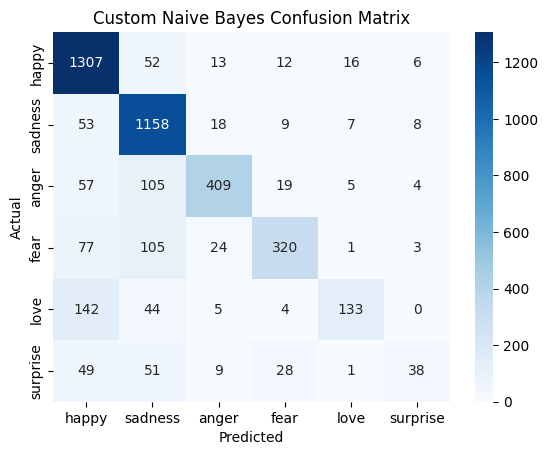

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", accuracy_score(test_data['Emotion'], test_data['predicted']))
print(classification_report(test_data['Emotion'], test_data['predicted']))

# Confusion Matrix
cm = confusion_matrix(test_data['Emotion'], test_data['predicted'], labels=list(model.class_priors.keys()))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(model.class_priors.keys()), yticklabels=list(model.class_priors.keys())) # Convert dict_keys to list
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Custom Naive Bayes Confusion Matrix")
plt.show()


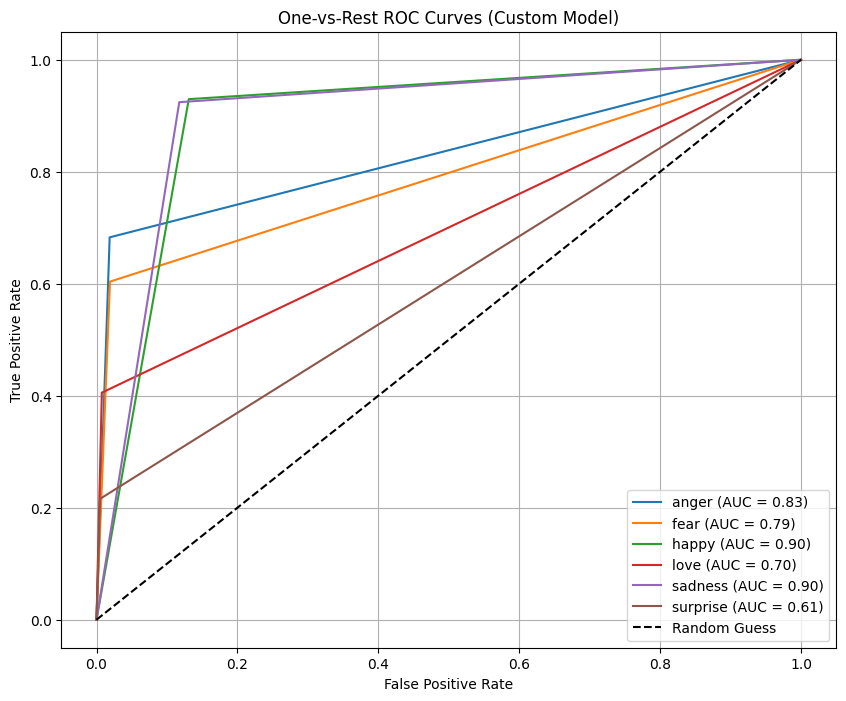

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(test_data['Emotion'])
y_pred_bin = lb.transform(test_data['predicted'])
labels = lb.classes_

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("One-vs-Rest ROC Curves (Custom Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


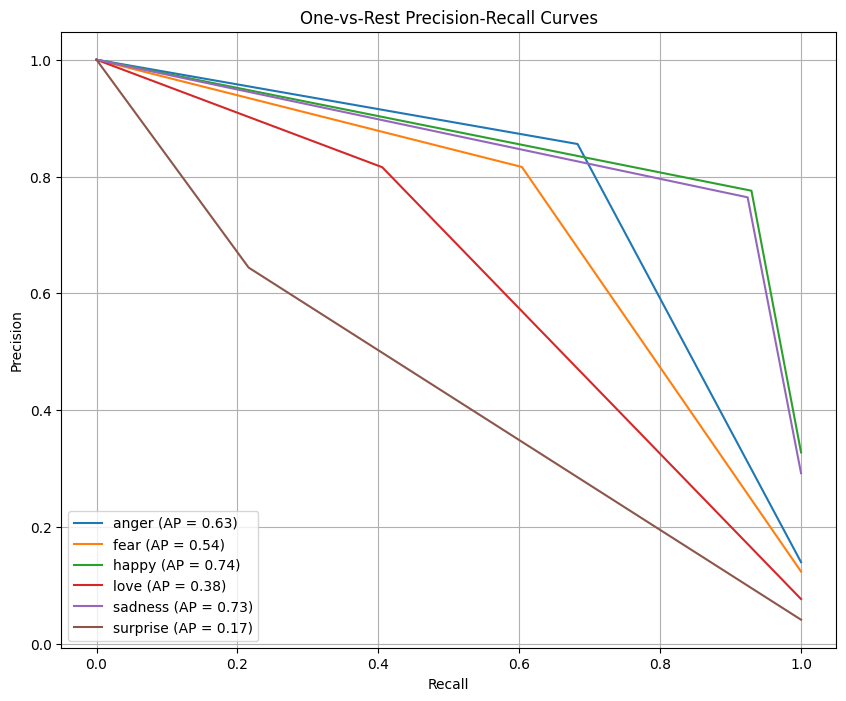

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, label=f"{label} (AP = {ap_score:.2f})")

plt.title("One-vs-Rest Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from scipy.stats import ttest_1samp

accuracies = (y_pred_bin == y_test_bin).mean(axis=0)
t_stat, p_value = ttest_1samp(accuracies, 0.5)

print("T-statistic:", t_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("Statistically significant: Model is better than random.")
else:
    print("Not statistically significant at p < 0.05.")


T-statistic: 35.253554517815445
P-value: 3.455831214251782e-07
Statistically significant: Model is better than random.
